In [ ]:
!gdown --id 1-BuoaHfAHasrSf7mb10N21brUI86rGxs

In [ ]:
!gdown --id 1nuNgS5I2GJpt3KUZQDBOXvZalkMi5krS

In [ ]:
!unzip -o resting-meditators2.zip

In [ ]:
!unzip -o resting-novices.zip

In [ ]:
!pip install -U mne

In [44]:
import mne
import numpy as np
import os
from scipy.signal import hilbert
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [45]:
# Define paths
meditators_dir = '/content/resting-meditators2'
novices_dir = '/content/resting-novices'
sfreq = 250

In [46]:
def load_and_prepare_data(directory, montage, notch_freq):
    raws = []
    # Load data
    for filename in os.listdir(directory):
        if filename.endswith('.fif'):
            path = os.path.join(directory, filename)
            raw = mne.io.read_raw_fif(path, preload=True)
            raw.notch_filter(notch_freq, filter_length='auto', phase='zero')
            raw.filter(0.5, 45)
            raw.crop(tmin=30, tmax=115)
            raw.set_montage(montage)
            raws.append(raw)
    return raws

# Create the standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')

In [ ]:
# Process the meditators and novices data
meditators_raws = load_and_prepare_data(meditators_dir, montage, 50)
novices_raws = load_and_prepare_data(novices_dir, montage, 50)

In [48]:
# raw = meditators_raws[0]

In [49]:
# fig = raw.compute_psd().plot_topomap(ch_type='eeg', normalize=True)

In [50]:
# _ = raw.compute_psd().plot()

In [51]:
# _ = raw.plot()

In [52]:
# raw.describe()

In [53]:
# raw

# EEG complexity (HFD)

Step 1: Calculate Complexity Measures for Both Groups

In [54]:
!pip install hfda

In [55]:
import hfda

def calculate_hfd_with_hfda(raws, k_max=5):
    """
    Calculate the average Higuchi Fractal Dimension (HFD) for each EEG recording using hfda library.

    Parameters:
    - raws: list of mne.io.Raw objects.
    - k_max: The max number of intervals for the HFD calculation, similar to Kmax in the previous approach.

    Returns:
    - A list of average HFD values, one per recording.
    """
    hfd_values = []
    for raw in raws:
        data = raw.get_data()
        # Calculate HFD for each channel and then average
        channel_hfds = [hfda.measure(data[i], k_max) for i in range(data.shape[0])]
        hfd_values.append(np.mean(channel_hfds))
    return hfd_values

In [56]:
meditators_hfd = calculate_hfd_with_hfda(meditators_raws, k_max=5)
novices_hfd = calculate_hfd_with_hfda(novices_raws, k_max=5)

In [57]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U Test
stat, p = mannwhitneyu(meditators_hfd, novices_hfd)

# Print the test results
print(f'Mann-Whitney U Statistic: {stat}, P-value: {p}')

# Check if the result is significant
alpha = 0.05

if p < alpha:
    print("The difference between meditators and novices is statistically significant.")
else:
    print("The difference between meditators and novices is not statistically significant.")



Mann-Whitney U Statistic: 67.0, P-value: 0.21229383619233155
The difference between meditators and novices is not statistically significant.


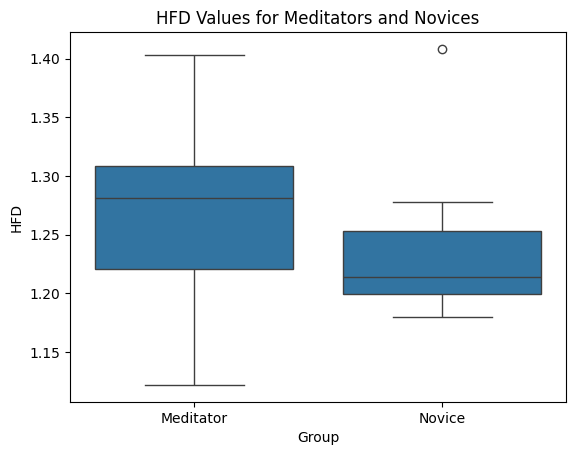

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine HFD values into a single dataset for plotting
hfd_values = np.concatenate((meditators_hfd, novices_hfd))
groups = ['Meditator'] * len(meditators_hfd) + ['Novice'] * len(novices_hfd)

data_df = pd.DataFrame({'Group': groups, 'HFD': hfd_values})

# Box plot
sns.boxplot(x='Group', y='HFD', data=data_df)
plt.title('HFD Values for Meditators and Novices')
plt.show()


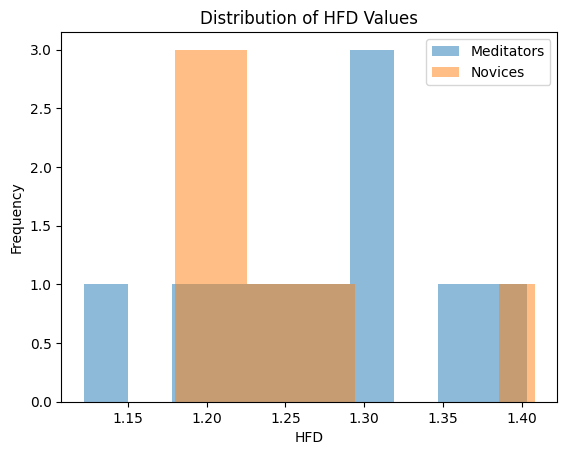

In [59]:
# Histogram
plt.hist(meditators_hfd, alpha=0.5, label='Meditators')
plt.hist(novices_hfd, alpha=0.5, label='Novices')
plt.title('Distribution of HFD Values')
plt.xlabel('HFD')
plt.ylabel('Frequency')
plt.legend()
plt.show()


<ipython-input-60-43cc6fa9dc3c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='HFD', data=data_df, palette="Set2")


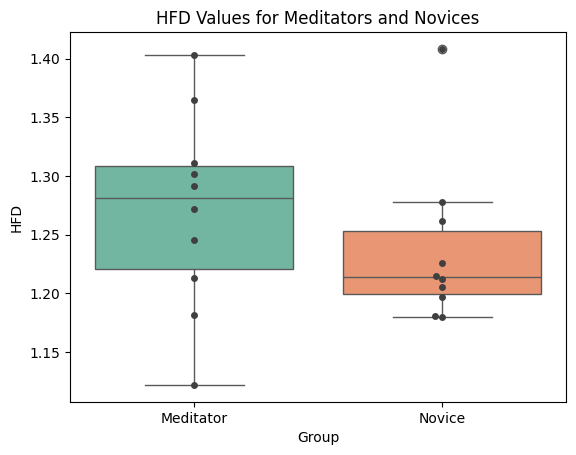

In [60]:
sns.boxplot(x='Group', y='HFD', data=data_df, palette="Set2")
sns.swarmplot(x='Group', y='HFD', data=data_df, color=".25")
plt.title('HFD Values for Meditators and Novices')
plt.show()


In [29]:
import numpy as np

def detect_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    outliers = np.where((data < lower_bound) | (data > upper_bound))
    return outliers[0]

# Apply to the meditators' HFD values
outliers_indices = detect_outliers_iqr(np.array(meditators_hfd))
print("Outliers indices:", outliers_indices)


Outliers indices: []


In [30]:
from scipy import stats

# Calculate z-scores of HFD values
z_scores = np.abs(stats.zscore(meditators_hfd))

# Get indices of potential outliers
outliers_z = np.where(z_scores > 3)
print("Outliers indices based on z-scores:", outliers_z[0])


Outliers indices based on z-scores: []


# ลองทำ psd welch ดู

In [41]:
import mne
import numpy as np
from scipy.stats import ttest_ind



def compute_psd(raws, fmin, fmax, n_fft):
    psds = []
    for raw in raws:
        # Extract data from the Raw object
        data, times = raw[:, :]
        # Compute PSD
        psd, freqs = mne.time_frequency.psd_array_welch(data, sfreq, fmin=fmin, fmax=fmax, n_fft=n_fft)
        psds.append(psd)
    return np.array(psds), freqs

# Define power bands
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 45)
}

n_fft = 2048

# Dictionary to hold the comparison results
comparison_results = {}

# Compute PSDs and compare each band
for band, (fmin, fmax) in bands.items():
    meditators_psds, freqs = compute_psd(meditators_raws, fmin, fmax, n_fft)
    novices_psds, freqs = compute_psd(novices_raws, fmin, fmax, n_fft)

    # Average the power bands for each group
    meditators_avg_psd = np.mean(meditators_psds, axis=1)
    novices_avg_psd = np.mean(novices_psds, axis=1)

    # Perform t-test between groups
    t_stat, p_value = ttest_ind(meditators_avg_psd, novices_avg_psd)

    # Store the results
    comparison_results[band] = {
        't_stat': t_stat,
        'p_value': p_value
    }

# Define a significance level
alpha = 0.05

# Print out the comparison results with significance statement
for band, results in comparison_results.items():
    t_stat = np.mean(results['t_stat']) if isinstance(results['t_stat'], np.ndarray) else results['t_stat']
    p_value = np.mean(results['p_value']) if isinstance(results['p_value'], np.ndarray) else results['p_value']

    print(f"{band} band: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")
    # Check if the result is significant
    if p_value < alpha:
        print(f"The difference in {band} band power between meditators and novices is statistically significant.\n")
    else:
        print(f"No significant difference in {band} band power between meditators and novices was found.\n")


Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective wind

Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective wind

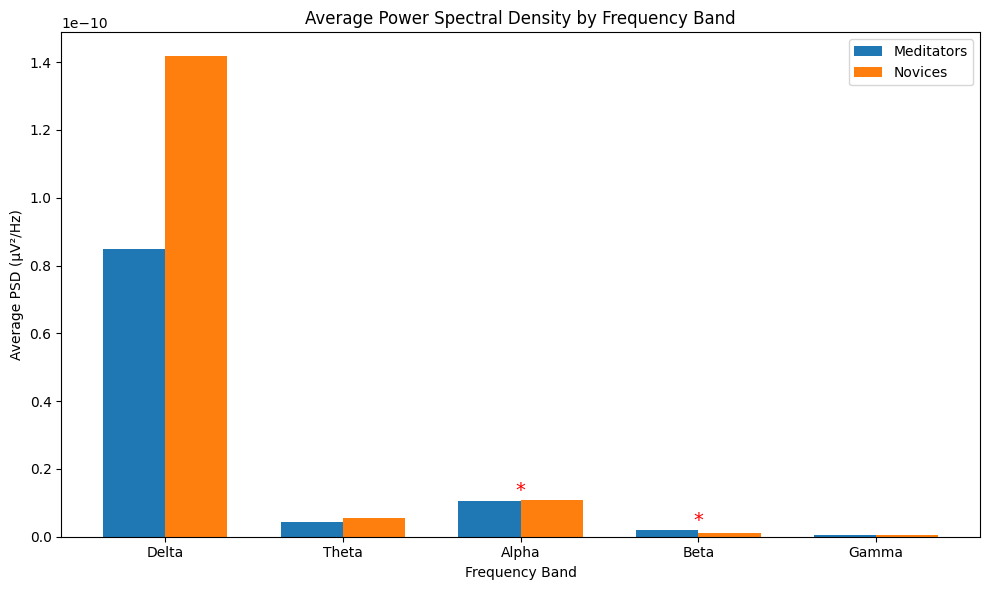

In [43]:
import matplotlib.pyplot as plt


avg_psds = {band: {'meditators': [], 'novices': []} for band in bands.keys()}
for band in bands.keys():
    # Compute average PSD across all meditators and all novices for the band
    avg_psds[band]['meditators'] = np.mean([np.mean(psd) for psd in compute_psd(meditators_raws, *bands[band], n_fft)[0]], axis=0)
    avg_psds[band]['novices'] = np.mean([np.mean(psd) for psd in compute_psd(novices_raws, *bands[band], n_fft)[0]], axis=0)

# Create a bar plot for each band
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(bands))

bar1 = ax.bar(index, [avg_psds[band]['meditators'] for band in bands.keys()], bar_width, label='Meditators')
bar2 = ax.bar(index + bar_width, [avg_psds[band]['novices'] for band in bands.keys()], bar_width, label='Novices')

# Add significance indicators
for i, band in enumerate(bands.keys()):
    # Handle the case where p_value is an array
    p_value = comparison_results[band]['p_value']
    if isinstance(p_value, np.ndarray):
        p_value = p_value.min()  # or .max(), .mean(), etc., depending on the desired logic
    if p_value < 0.05:
        ax.text(i + bar_width / 2, max(avg_psds[band]['meditators'], avg_psds[band]['novices']), '*', ha='center', va='bottom', color='red', fontsize=14)

ax.set_xlabel('Frequency Band')
ax.set_ylabel('Average PSD (µV²/Hz)')
ax.set_title('Average Power Spectral Density by Frequency Band')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(bands.keys())
ax.legend()

plt.tight_layout()
plt.show()
